<a href="https://colab.research.google.com/github/Zokoban/pyOCRTEN/blob/Full_TensorFlow/ocr_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download all data on the drive 

In [1]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

## Load all the required packages

In [2]:
import pandas as pd
import numpy as np
import csv
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## Load word.txt file

In [3]:
word_txt=pd.read_csv("data/words.txt",sep=' ',names=["word_id","segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","transcription_1","transcription_2","transcription_3"] ,quoting=csv.QUOTE_NONE,skiprows=18,on_bad_lines="warn")

def f(x):
    if x == "nan":
        return ""
    else:
        return x
word_txt["transcription"]=word_txt.transcription_1.astype("str")+word_txt.transcription_2.astype("str").apply(f)+word_txt.transcription_3.astype("str").apply(f)
word_txt=word_txt.drop(columns=["transcription_1","transcription_2","transcription_3"])

def f(x):
    return len(x)

word_txt["number_components"]=word_txt.transcription.apply(f)

print("word_txt Length: ",len(word_txt))
word_txt.head()

word_txt Length:  115320


,word_id,segmentation_result,gray_level,x,y,pxw,pxh,grammatical_tag,transcription,number_components
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,1
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,4
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,2
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,4
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,3


### Choice of the fraction of the dataset.
### Removal of the transcription error.
### Removal of the unwanted columns.

In [13]:
list_columns_to_remove=["segmentation_result","gray_level","x","y","pxw","pxh","grammatical_tag","number_components"]
fraction = 0.5
df = word_txt[word_txt.segmentation_result == "ok"]\
    .drop(columns=list_columns_to_remove)\
    .sample(frac=fraction)
  
print("df Length: ",len(df))
df.head()

df Length:  48228


,word_id,transcription
36873,d06-041-06-05,before
9302,a04-031-09-10,","
78466,j01-059-05-08,seal
13132,a06-051-01-06,.
4906,a02-004-02-02,Macmillan


## Separation of dataset and Loading + Preprocessing of the image

###Loading and preprocessing functions

In [74]:
import tensorflow as tf


def img_path(word):
    path="data/words/"+word.split("-")[0]+"/"+word.split("-")[0]+"-"+word.split("-")[1]+"/"+word+".png"
    
    return path

@tf.function
def load_image(filepath):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=0)

    return im


@tf.function
def preprocess(filepath, imgSize=(32, 128), dataAugmentation=False, scale=0.8, isthreshold=False):

    img = load_image(filepath)/255
    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = tf.ones([imgSize[0], imgSize[1], 1])
        print("None")

    if dataAugmentation:
        stretch = scale*(tf.random.uniform([1], 0, 1)[0] - 0.3) # -0.5 .. +0.5
        wStretched = tf.maximum(int(float(tf.shape(img)[0]) * (1 + stretch)), 1) # random width, but at least 1
        img = tf.image.resize(img, (wStretched, tf.shape(img)[1])) # stretch horizontally by factor 0.5 .. 1.5

    (wt, ht) = imgSize

    w, h = float(tf.shape(img)[0]), float(tf.shape(img)[1])

    fx = w / wt
    fy = h / ht

    f = tf.maximum(fx, fy)

    newSize = (tf.maximum(tf.minimum(wt, int(w / f)), 1), tf.maximum(tf.minimum(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)

    img = tf.image.resize(img, newSize)


    dx = wt - newSize[0]
    dy = ht - newSize[1]

    if dataAugmentation :
        dx1=0
        dy1=0
        if dx!=0:
            dx1 = tf.random.uniform([1], 0, dx, tf.int32)[0]
        if dy!=0:
            dy1 = tf.random.uniform([1], 0, dy, tf.int32)[0]
        img = tf.pad(img[..., 0], [[dx1, dx-dx1], [dy1, dy-dy1]], constant_values=1)
    else :
        img = tf.pad(img[..., 0], [[0, dx], [0, dy]], constant_values=1)

    if isthreshold:
        return tf.expand_dims(1-(1-img)*tf.cast(img < 0.8, tf.float32), -1)
    return tf.expand_dims(img, -1)


df["filepath"]=df.word_id.apply(img_path)

df.head()

,word_id,transcription,filepath
36873,d06-041-06-05,before,data/words/d06/d06-041/d06-041-06-05.png
9302,a04-031-09-10,",",data/words/a04/a04-031/a04-031-09-10.png
78466,j01-059-05-08,seal,data/words/j01/j01-059/j01-059-05-08.png
13132,a06-051-01-06,.,data/words/a06/a06-051/a06-051-01-06.png
4906,a02-004-02-02,Macmillan,data/words/a02/a02-004/a02-004-02-02.png


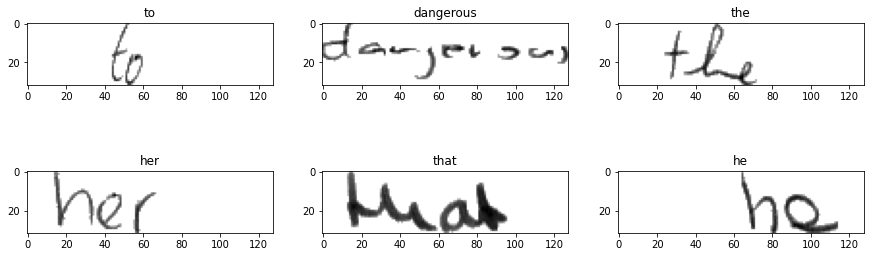

In [75]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train_path, X_test_path, y_train, y_test = train_test_split(df.filepath.values, df.transcription.values, train_size=0.9, random_state=1234)

batch_size = 64
imgSize = (32, 128)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
dataset_train = dataset_train.shuffle(10000).map(
    lambda x, y : [preprocess(x, imgSize, dataAugmentation=True, scale=0.8, isthreshold=True), y]).batch(batch_size, drop_remainder=True)


X_t, y_t = next(iter(dataset_train))


plt.figure(figsize=(15,5))
for j, i in enumerate(np.random.randint(low=0, high=len(X_t), size=[6])):
    plt.subplot(2,3,j+1)
    plt.imshow(X_t[i][...,0], cmap='gray')
    plt.title(y_t[i].numpy().decode('utf'))

## Vectorization of the labels

In [76]:
import string
charList = list(string.ascii_lowercase)

def encode_labels(labels):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(charList, np.arange(len(charList)), value_dtype=tf.int32),
        default_value = -1,
        name='chard2id')
    return table.lookup(tf.compat.v1.string_split(labels, sep=''))


def loss(labels, logits):
    return tf.reduce_mean(tf.nn.ctc_loss(
        labels = labels,
        logits = logits,
        logit_length = [logits.shape[1]]*logits.shape[0],
        label_length = None,
        logits_time_major = False,
        blank_index=-1))


dataset = dataset_train.map(lambda X,y : [X, encode_labels(y)])


dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test))
dataset_test = dataset_test.map(
    lambda x, y : [preprocess(x, imgSize, dataAugmentation=True, scale=0.8, isthreshold=True), y]).batch(batch_size, drop_remainder=True)
dataset_test = dataset_test.map(lambda X,y : [X, encode_labels(y)])

#Modelisation

## Model_1

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

def build_model_1(input_shape,output_vector_length):
  ###Lenet model
  model = Sequential()
  model.add(Conv2D(filters=32,
                   kernel_size=(3, 3),
                   activation='relu',
                   input_shape=input_shape))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(filters=64,
                   kernel_size=(3, 3),
                   activation='relu',
                   padding = 'same'))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))

  model.add(Conv2D(filters=128,
                   kernel_size=(3, 3),
                   activation='relu',
                   padding = 'valid'))
  model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))

  model.add(Flatten())

  model.add(Dense(64,activation ="relu"))
  model.add(Dense(128,activation ="relu"))
  model.add(Dense(output_vector_length,activation ="relu"))

  model

  return model

In [ ]:
model_input_shape=(h,w,1)
model_1=build_model_1(model_input_shape,max_length)

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 130, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 65, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 65, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 32, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 30, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 15, 128)      

In [ ]:
plt.plot(range(1,epochs+1),val_acc_lenet,label="lenet_validation")
plt.plot(range(1,epochs+1),train_acc_lenet,label="lenet_train")
plt.legend();

## Model_2

In [49]:
#@title
from tensorflow import keras
import tensorflow as tf

h,w = 32,128
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(h, w, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((w // 4), (h // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(le.classes_) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img,labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model_2 = build_model()
model_2.summary()

NameError: ignored

In [ ]:
#@title
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

TypeError: ignored

In [ ]:
#@title
epochs = 10  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)


# Train the model.
history = model.fit(dataset_train,    
                    epochs=epochs)

Epoch 1/10
171/603 [=======>......................] - ETA: 19s - loss: 18.6990

KeyboardInterrupt: ignored

In [ ]:
#@title

train_ds =  tf.data.Dataset.from_tensor_slices((X_train_reshaped, y_train_encode))
validation_ds = tf.data.Dataset.from_tensor_slices((X_test_reshaped, y_test_encode))

In [ ]:
#@title
train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 132), dtype=tf.float64, name=None), TensorSpec(shape=(19,), dtype=tf.int64, name=None))>

In [ ]:
#@title


In [ ]:
#@title


In [ ]:
#@title


In [ ]:
#@title


In [ ]:
#@title


## Model_3

In [77]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, LeakyReLU, Dropout
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Lambda
numHidden = 256

def build_model_3():
  #Create_model_CRNN
    model = tf.keras.Sequential()

    # Layer 1
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='SAME', input_shape = X_t.shape[1:]))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 2
    model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Layer 3
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    # Layer 4
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    # Layer 5
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='SAME'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))
    model.add(Dropout(0.4))


    model.add(Lambda(lambda x :tf.squeeze(x, axis=1)))

    # Bidirectionnal RNN
    model.add(Bidirectional(GRU(numHidden, return_sequences=True)))
    # Classification of characters
    model.add(Dense(len(charList)+1))
    return model

model_3 = build_model_3()
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 128, 32)       832       
                                                                 
 batch_normalization_30 (Bat  (None, 32, 128, 32)      128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 64, 64)        51264     
                                                                 
 batch_normalization_31 (Bat  (None, 16, 64, 64)      

#Compilation

###Model_1

In [ ]:
model_1.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


###Model_2

###Model_3

In [78]:
from tensorflow.keras.optimizers import Adam
model_3.compile(optimizer=Adam(1e-3),loss=loss)

#Training

###Model_1

In [ ]:
epochs=5
training_history_model_1=model_1.fit(X_train_reshaped,y_train_encode,epochs=epochs,batch_size=150, validation_data = (X_test_reshaped,y_test_encode))

In [ ]:
train_acc_model_1 = training_history_lenet.history['accuracy']
val_acc_model_1 = training_history_lenet.history['val_accuracy']

###Model_3

In [71]:
training_history=model_3.fit(dataset,epochs=2, validation_data=dataset_test)

Epoch 1/2
 61/678 [=>............................] - ETA: 38s - loss: 14.8964

InvalidArgumentError: ignored

In [56]:
i=0
for X_t, y_t in dataset_train:
  for x in X_t:

    if tf.equal(tf.size(x), 0):
      print("Empty")
    i=i+1

InvalidArgumentError: ignored

## Decode the vector

In [ ]:
def decode_codes(codes):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            np.arange(len(charList)),
            charList,
            key_dtype=tf.int32
        ),
        '',
        name='id2char'
    )
    return table.lookup(codes)

b = decode_codes(encode_labels(y_train[0:5]))
b.values

# Prediction